In [9]:
import numpy as np
import os
import gzip
import struct
import random
import time
import signal
import urllib
from IPython.display import clear_output, display

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.autograd import Variable
import torchvision.transforms as T

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'gray'

## Load data

In [15]:
dst = "data/"
base = "http://yann.lecun.com/exdb/mnist/"
files = [
    "train-images-idx3-ubyte.gz",
    "train-labels-idx1-ubyte.gz",
    "t10k-images-idx3-ubyte.gz",
    "t10k-labels-idx1-ubyte.gz",
]

os.makedirs(dst, exist_ok=True)

for file in files:
    if os.path.isfile(dst + file):
        print("file '%s' already exists" % file)
    else:
        print("downloading '%s' ..." % (base + file))
        urllib.request.urlretrieve(base + file, dst + file)

file 'train-images-idx3-ubyte.gz' already exists
file 'train-labels-idx1-ubyte.gz' already exists
file 't10k-images-idx3-ubyte.gz' already exists
file 't10k-labels-idx1-ubyte.gz' already exists


In [19]:
def loadlabels(filepath):
    with gzip.open(filepath, "rb") as f:
        _magic, n = struct.unpack(">ll", f.read(2*4))
        assert(_magic == 2049)
        return np.frombuffer(f.read(n), dtype=np.dtype("B"))

def loadimages(filepath):
    with gzip.open(filepath, "rb") as f:
        _magic, n, sx, sy = struct.unpack(">llll", f.read(4*4))
        assert(_magic == 2051)
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(-1, 1, sx, sy).astype(np.float64)/255.0
        return ((sx, sy), images)

def load(labelsfp, imagesfp):
    labels = loadlabels(labelsfp)
    size, images = loadimages(imagesfp)
    assert(labels.shape[0] == images.shape[0])
    return (size, labels, images)

In [20]:
ddir = "data/"
print("loading train set")
imgsize, train_labels, train_images = load(ddir + "train-labels-idx1-ubyte.gz", ddir + "train-images-idx3-ubyte.gz")

print("loading test set")
_imgsize, test_labels, test_images = load(ddir + "t10k-labels-idx1-ubyte.gz", ddir + "t10k-images-idx3-ubyte.gz")

assert(imgsize == _imgsize)

loading train set
loading test set


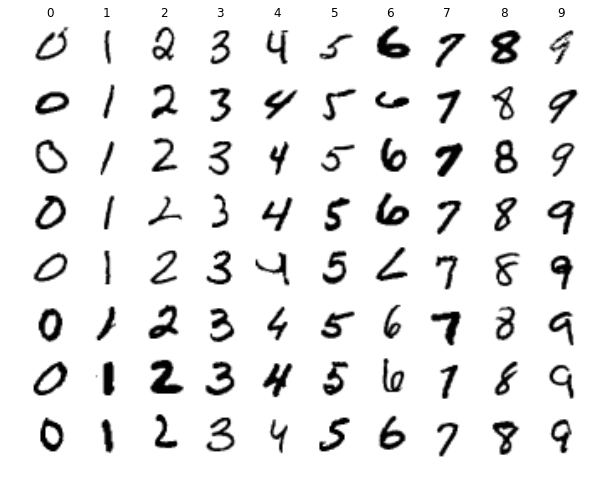

In [21]:
rows = 8
for digit in range(10):
    idxs = np.flatnonzero(np.equal(test_labels, digit))
    idxs = np.random.choice(idxs, rows, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(rows, 10, 10*i + digit + 1)
        plt.imshow(255.0*(1.0 - test_images[idx][0]))
        plt.axis('off')
        if i == 0:
            plt.title(digit)

## Functions and classes

In [22]:
signal_done = False

def signal_handler(signal, frame):
    global signal_done
    signal_done = True

def stop_on_signal():
    global signal_done
    signal_done = False
    signal.signal(signal.SIGINT, signal_handler)

In [23]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size()
        return x.view(N, -1)

In [24]:
class ConvNet(nn.Module):
    def __init__(self, conv, fc, ksize=3):
        super().__init__()
        
        self.kernel_size = ksize
        pad = (ksize - 1)//2;
        
        levels = []
        for level in conv:
            layers = []
            for conv_in, conv_out in zip(level[:-1], level[1:]):
                layers.extend([
                    nn.Conv2d(conv_in, conv_out, kernel_size=ksize, padding=pad),
                    #nn.BatchNorm2d(conv_out),
                    nn.ReLU(),
                ])
            layers.append(nn.MaxPool2d(2, stride=2))
            levels.append(nn.ModuleList(layers))
        self.conv = nn.ModuleList(levels)
        
        layers = [Flatten()]
        for fc_in, fc_out in zip(fc[:-1], fc[1:]):
            layers.extend([
                nn.Linear(fc_in, fc_out),
                #nn.BatchNorm1d(fc_out),
                nn.ReLU(),
            ])
        layers.pop()
        self.fc = nn.ModuleList(layers)
    
    def forward(self, x):
        for d in self.conv:
            for l in d:
                #print(x.shape)
                x = l(x)
            
        for l in self.fc:
            #print(x.shape)
            x = l(x)

        return x

In [25]:
class History:
    def __init__(self):
        self.t = []
        self.acc = []
        self.loss = []
        
    def append(self, t, acc, loss):
        self.t.append(t)
        self.acc.append(acc)
        self.loss.append(loss)

In [26]:
def plot(train, test):
    plt.subplot(2, 1, 1)
    plt.plot(train.t, train.loss, label="Train loss: %.4f" % train.loss[-1])
    plt.plot(test.t, test.loss, label="Test loss: %.4f" % test.loss[-1])
    plt.title("Loss")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(train.t, train.acc, label="Train accuracy: %.2f%%" % (100.0*train.acc[-1]))
    plt.plot(test.t, test.acc, label="Test accuracy: %.2f%%" % (100.0*test.acc[-1]))
    plt.title("Accuracy")
    plt.legend()
    
    plt.show()

In [27]:
def shuffle_sync(seqs):
    perm = np.random.permutation(seqs[0].shape[0])
    return [s[perm] for s in seqs]

In [35]:
def step(model, optim, loss_fn, images, labels, train=True):
    if train:
        model.train()
    else:
        model.eval()
    
    images_var = Variable(Tensor(images).cuda())
    labels_var = Variable(Tensor(labels).cuda().long())
    
    if train:
        optim.zero_grad()

    pred_labels_var = model(images_var)
    loss = loss_fn(pred_labels_var, labels_var)
    
    if train:
        loss.backward()
        optim.step()
    
    pred_labels = np.argmax(pred_labels_var.data.cpu().numpy(), axis=1)
    #print(pred_labels)
    #print(labels)
    accuracy = np.mean(np.equal(pred_labels, labels))
    
    return loss.data.item(), accuracy

def train(*args, **kwargs):
    return step(*args, **kwargs, train=True)

def test(*args, **kwargs):
    with torch.no_grad():
        return step(*args, **kwargs, train=False)

## Hyperparameters search process

In [36]:
def probe(epochs, model, bs, lr, reg=0):
    loss_fn = nn.CrossEntropyLoss().cuda()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    max_acc = 0.0
    for k in range(epochs):
        sh_train_images, sh_train_labels = shuffle_sync([train_images, train_labels])
        for i in range((sh_train_labels.shape[0]-1)//bs + 1):
            labels = sh_train_labels[i:i+bs]
            images = sh_train_images[i:i+bs]
            train(model, optimizer, loss_fn, images, labels)
        test_loss, test_acc = test(model, None, loss_fn, test_images, test_labels)
        max_acc = max(test_acc, max_acc)
    return max_acc

In [ ]:
for lr in [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]:
    acc = probe(
        epochs=10,
        model=ConvNet(
            conv=(
                (1, 2),
                (2, 4),
            ),
            fc=(7*7*4, 10),
            ksize=3,
        ).cuda(),
        bs=100,
        lr=lr
    )
    print("lr: %s, acc: %s" % (lr, acc))

In [ ]:
for lr in [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 5e-4]:
    acc = probe(
        epochs=10,
        model=ConvNet(
            conv=(
                (1, 2),
                (2, 4),
            ),
            fc=(7*7*4, 10),
            ksize=3,
        ).cuda(),
        bs=100,
        lr=lr
    )
    print("lr: %s, acc: %s" % (lr, acc))

In [38]:
best_lr = 1e-3

In [66]:
for bs in [50, 100, 200, 500, 1000]:
    acc = probe(
        epochs=10,
        model=ConvNet(
            conv=(
                (1, 2),
                (2, 4),
            ),
            fc=(7*7*4, 10),
            ksize=3,
        ).cuda(),
        bs=bs,
        lr=best_lr
    )
    print("bs: %s, acc: %s" % (bs, acc))

bs: 50, acc: 0.9485
bs: 100, acc: 0.9284
bs: 200, acc: 0.929
bs: 500, acc: 0.9337
bs: 1000, acc: 0.9355


In [67]:
for bs in [500, 1000, 2000, 5000]:
    acc = probe(
        epochs=10,
        model=ConvNet(
            conv=(
                (1, 2),
                (2, 4),
            ),
            fc=(7*7*4, 10),
            ksize=3,
        ).cuda(),
        bs=bs,
        lr=best_lr
    )
    print("bs: %s, acc: %s" % (bs, acc))

bs: 500, acc: 0.9327
bs: 1000, acc: 0.9268
bs: 2000, acc: 0.9328
bs: 5000, acc: 0.84


In [39]:
best_bs = 1000

In [41]:
model = ConvNet(
    conv=(
        (1, 2),
        (2, 4),
    ),
    fc=(7*7*4, 10),
    ksize=3,
).cuda()

## Final run

In [42]:
batch_size = 1000
loss_fn = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)#, weight_decay=1e-2)

In [43]:
epoch = 0
train_history, test_history = History(), History()

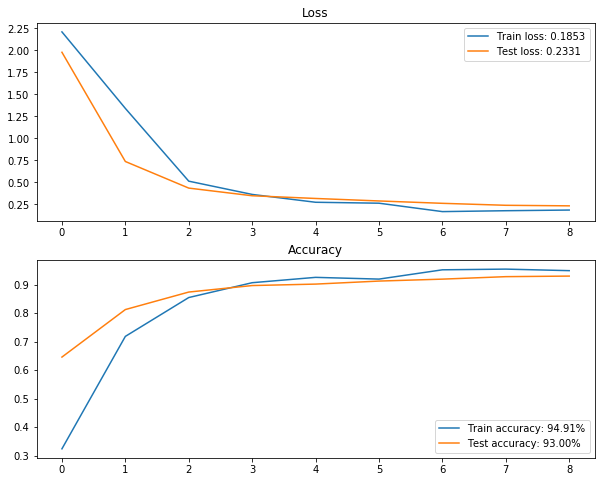

In [ ]:
stop_on_signal()
while not signal_done:
    train_loss = 0.0
    train_acc = 0.0
    
    sh_train_images, sh_train_labels = shuffle_sync([train_images, train_labels])
    for i in range((sh_train_labels.shape[0]-1)//batch_size + 1):
        labels = sh_train_labels[i:i+batch_size]
        images = sh_train_images[i:i+batch_size]
        loss, acc = train(model, optimizer, loss_fn, images, labels)
        part = labels.shape[0]/train_labels.shape[0]
        train_loss += loss*part
        train_acc += acc*part
    
    train_history.append(epoch, train_acc, train_loss)

    test_loss, test_acc = test(model, None, loss_fn, test_images, test_labels)
    test_history.append(epoch, test_acc, test_loss)

    clear_output(wait=True)
    plot(train_history, test_history)
    
    epoch += 1